Contribution from filaments. The importance of them is discussed in [Kaurov&Gnedin (2016)](https://ui.adsabs.harvard.edu/#abs/2016ApJ...824..114K/abstract) and their contribution to the 21cm PS can be of order 50%. In [Kaurov (2016)](https://ui.adsabs.harvard.edu/#abs/2016ApJ...831..198K/abstract) a simple approach to fix it is proposed.

In [1]:
# we start with importing all necessary components
%matplotlib inline

import numpy as np
from numpy import sin, cos, pi

import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from IPython.display import HTML

from scipy.stats import rankdata, norm

# FastPM related libraries to work with snapshots
from nbodykit.source.catalog.file import BigFileCatalog
from nbodykit.source.mesh import BigFileMesh

from nbodykit.cosmology import Planck15
from nbodykit.cosmology import EHPower

from nbodykit.lab import *
from nbodykit import setup_logging, style

from skimage import measure

from reionprimer import *

/home/kaurov/anaconda3/envs/cfastpm/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


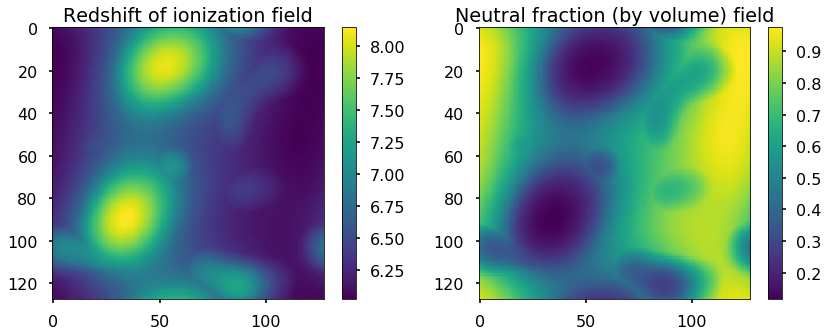

In [2]:
N=128
boxsize=10

part = BigFileCatalog('fastpm_0.1250', dataset='1/', header='Header')
q = part.to_mesh(Nmesh=N)
q = q.to_field()

halos = BigFileCatalog('fastpm_0.1250/fof/0.200/',header='Header')

M = np.array(halos['Mass'])
pos = np.array(halos['CMPosition'])

# we want to take only halos above 10^10 M_\Sun
filt = (M>1e9)

halo_field_m = np.zeros([N,N,N])

for i,(m,x,y,z) in enumerate(zip(M[filt],
                                 (pos[filt,0])/boxsize*N, 
                                 (pos[filt,1])/boxsize*N, 
                                 (pos[filt,2])/boxsize*N)):
    halo_field_m[int(x),int(y),int(z)] += 1.0 * m


# halo_field += q*1e10

def barrier(s, h):
#     return s*0 + 0.9
    return 4*(np.log10(s)+0.0)**2+h

def r_barrier(s, v):
    return v-4*(np.log10(s)+0.0)**2

sm_scales=np.array([1,2,4,8,16,32,64,128,256])
halo_field = halo_field_m + q*1e-2
field = get_trajectories(halo_field, sm_scales=sm_scales, filter_mode='gaussian', normalization='rankorder')

h_field = np.zeros([N,N,N,len(sm_scales)])
for i,scale in enumerate(sm_scales):
    h_field[:, :, :, i] = r_barrier(N/scale/boxsize, field[:,:,:,i])

h_field = h_field.max(3)

z_list = np.linspace(15,5,100)
f_list = reion_history(z_list)
f_field, z_field = convert_to_h_field(h_field, z_list, f_list)

plt.figure(figsize=(14,5))
plt.subplot(121)
plt.imshow(z_field[0,:,:])
plt.title('Redshift of ionization field')
plt.colorbar()
plt.subplot(122)
plt.imshow(f_field[0,:,:])
plt.title('Neutral fraction (by volume) field')
plt.colorbar()

## Filaments

Neutral fraction in the filaments is proportinal to its local density. This model of late reionization is proposed by [Miralda-Escude et al. (2000)](https://ui.adsabs.harvard.edu/#abs/2000ApJ...530....1M/abstract). It is also applicable to the interiors of the ionized bubbles during the reionization. The way it is implemented further assumes uniform ionizing background in each bubble. This assumption obviously is not true, but we will keep it for simplicity.

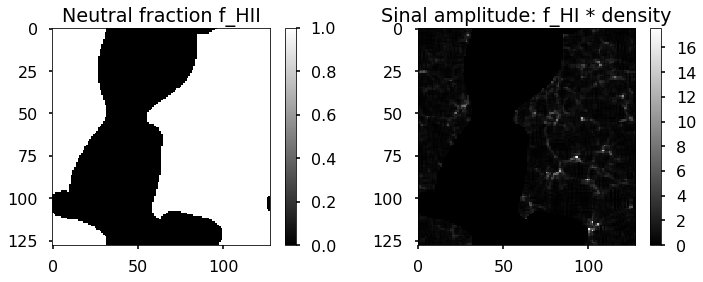

In [3]:
fHI = 1.0*(f_field>0.5)

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.title('Neutral fraction f_HII')
plt.imshow(fHI[0,:,:], cmap='gray')
plt.colorbar()

plt.subplot(122)
plt.title('Sinal amplitude: f_HI * density')
plt.imshow((fHI*q)[0,:,:], cmap='gray')
plt.colorbar()

/home/kaurov/anaconda3/envs/cfastpm/lib/python3.5/site-packages/pmesh/pm.py:115: RuntimeWarning: divide by zero encountered in power
  r[...] = self[...] ** other


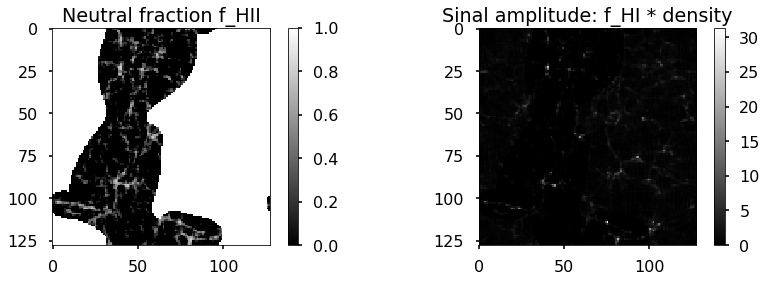

In [4]:


def add_filaments(fHI_IGM, density, n_c=2.5):
    """Adding filaments to the simulation

    Under the assumption that the filaments are resolved and optically
    thin to the ionizing background, we can apply a simple rule for
    estimating the neutral fraction. Naively you can think :

    Args:
        fHI_IGM (3d float array): Original neutral fraction field of IGM.
        density (3d float array): Density.
        n_c     (float):          Coefficient.

    Returns:
        fHI_mod: Neutral fraction field that includes filaments.

    """
    fHI_mod = fHI_IGM.copy()
    fHI_mod += 1.0-n_c*q**-0.5
    fHI_mod[fHI_IGM==1]=1
    fHI_mod[fHI_mod>1] = 1
    fHI_mod[fHI_mod<0] = 0
    return fHI_mod


plt.figure(figsize=(14,4))
fHI_mod = add_filaments(fHI, q, n_c=1.)
plt.subplot(121)
plt.title('Neutral fraction f_HII')
plt.imshow(fHI_mod[0,:,:], cmap='gray')
plt.colorbar()

plt.subplot(122)
plt.title('Sinal amplitude: f_HI * density')
plt.imshow((fHI_mod*q)[0,:,:], cmap='gray')
plt.colorbar()

In [5]:
k_list=np.logspace(np.log10(1./(N+1)),0,20)
k_list_phys=2.*np.pi*k_list*N/boxsize
k_list_phys_centers=(k_list_phys[1:] * k_list_phys[:-1])**0.5

PS_HI = pk((fHI*q), boxsize, k_list_phys)
PS_HI_mod = pk((fHI_mod*q), boxsize, k_list_phys)

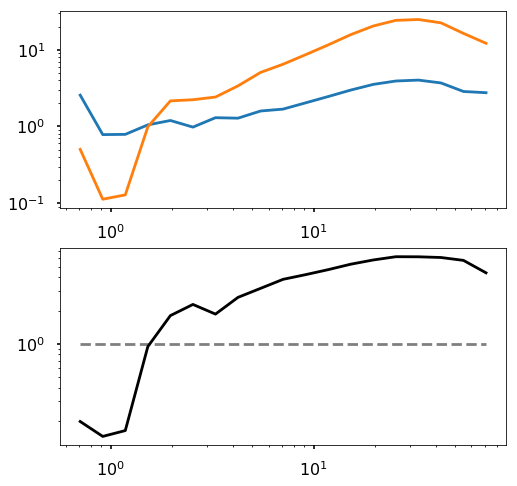

In [6]:
plt.figure(figsize=(8,8))

plt.subplot(211)
plt.plot(k_list_phys_centers, PS_HI*k_list_phys_centers**3)
plt.plot(k_list_phys_centers, PS_HI_mod*k_list_phys_centers**3)
plt.xscale('log')
plt.yscale('log')

plt.subplot(212)
plt.plot(k_list_phys_centers, PS_HI_mod/PS_HI, 'k')
plt.plot(k_list_phys_centers, k_list_phys_centers*0.0+1., '--k', alpha=0.5)
plt.yscale('log')
plt.xscale('log')
# plt.yscale('log')

# Proximity effect

In [7]:
radiation_field = smooth(halo_field, r=0.5, N=N, data_in_fourier_space=False, mode='r^-2')

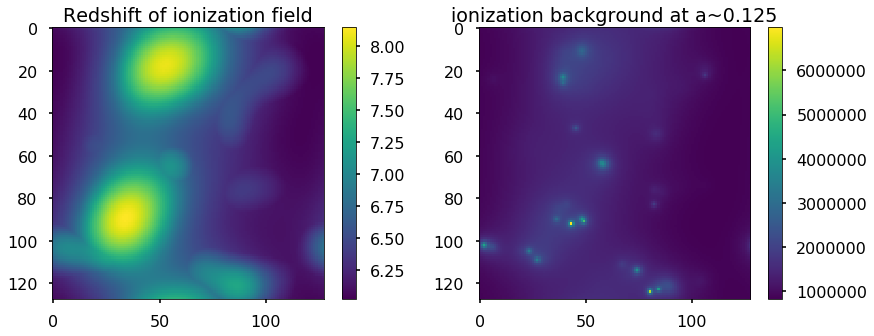

In [8]:
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.imshow(z_field[0,:,:])
plt.title('Redshift of ionization field')
plt.colorbar()
plt.subplot(122)
plt.imshow(radiation_field[0,:,:])
plt.title('ionization background at a~0.125')
plt.colorbar()

In [9]:
def add_filaments_with_proximity(fHI_IGM, density, flux, n_c=2.5):
    """Adding filaments to the simulation

    Under the assumption that the filaments are resolved and optically
    thin to the ionizing background, we can apply a simple rule for
    estimating the neutral fraction. Naively you can think :

    Args:
        fHI_IGM (3d float array): Original neutral fraction field of IGM.
        density (3d float array): Density.
        n_c     (float):          Coefficient.

    Returns:
        fHI_mod: Neutral fraction field that includes filaments.

    """
    fHI_mod = fHI_IGM.copy()
    fHI_mod += 1.0-n_c*q**-0.5*radiation_field**0.5
    fHI_mod[fHI_IGM==1]=1
    fHI_mod[fHI_mod>1] = 1
    fHI_mod[fHI_mod<0] = 0
    return fHI_mod


/home/kaurov/anaconda3/envs/cfastpm/lib/python3.5/site-packages/pmesh/pm.py:115: RuntimeWarning: divide by zero encountered in power
  r[...] = self[...] ** other


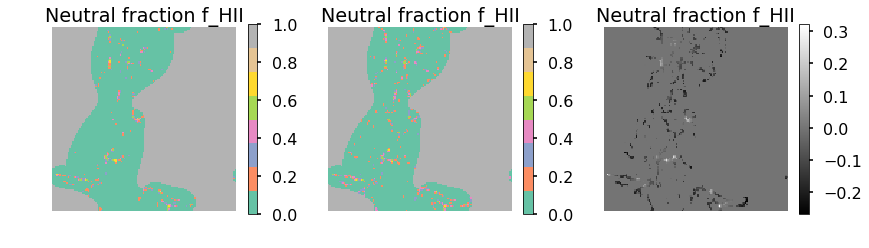

In [10]:
plt.figure(figsize=(14,3.5))

fHI_mod = add_filaments(fHI, q, n_c=1.5)
plt.subplot(131)
plt.title('Neutral fraction f_HII')
plt.imshow(fHI_mod[0,:,:], cmap='Set2')
plt.axis('off')
plt.colorbar()

fHI_prox_mod = add_filaments_with_proximity(fHI, q, radiation_field, n_c=1e-3)
plt.subplot(132)
plt.title('Neutral fraction f_HII')
plt.imshow(fHI_prox_mod[0,:,:], cmap='Set2')
plt.axis('off')
plt.colorbar()

plt.subplot(133)
plt.title('Neutral fraction f_HII')
plt.imshow((fHI_mod-fHI_prox_mod)[0,:,:], cmap='gray')
plt.axis('off')
plt.colorbar()


In [11]:

PS_HI = pk((fHI*q), boxsize, k_list_phys)
PS_HI_mod = pk((fHI_mod*q), boxsize, k_list_phys)
PS_HI_prox_mod = pk((fHI_prox_mod*q), boxsize, k_list_phys)

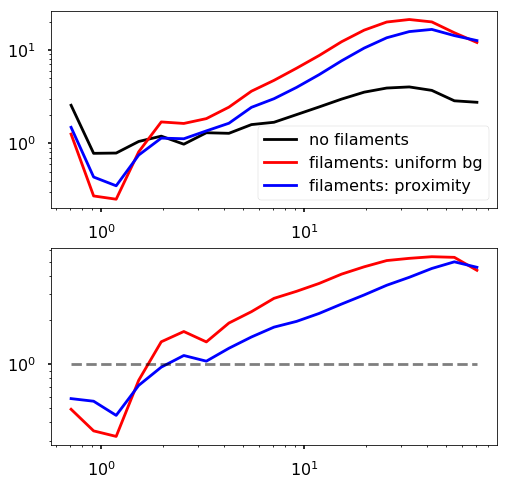

In [12]:
plt.figure(figsize=(8,8))

plt.subplot(211)
plt.plot(k_list_phys_centers, PS_HI*k_list_phys_centers**3, 'k', label = 'no filaments')
plt.plot(k_list_phys_centers, PS_HI_mod*k_list_phys_centers**3, 'r', label = 'filaments: uniform bg')
plt.plot(k_list_phys_centers, PS_HI_prox_mod*k_list_phys_centers**3, 'b', label = 'filaments: proximity')
plt.xscale('log')
plt.yscale('log')
plt.legend()

plt.subplot(212)
plt.plot(k_list_phys_centers, PS_HI_mod/PS_HI, 'r')
plt.plot(k_list_phys_centers, PS_HI_prox_mod/PS_HI, 'b')
plt.plot(k_list_phys_centers, k_list_phys_centers*0.0+1., '--k', alpha=0.5)
plt.yscale('log')
plt.xscale('log')
# plt.yscale('log')